In [1]:
import logging
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger

from neural_bandits.bandits.combinatorial_neural_ucb import CombinatorialNeuralUCBBandit
from neural_bandits.benchmark.datasets.abstract_dataset import AbstractDataset
from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator
from neural_bandits.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
class SyntheticCombinatorialDataset(AbstractDataset):
    """Synthetic dataset for Combinatorial Neural Bandit experiments.
    
    Implements the score functions from Hwang et al. "Combinatorial Neural Bandits" (section 5):
    - Linear: h₁(x) = x^T a
    - Quadratic: h₂(x) = (x^T a)²
    - Cosine: h₃(x) = cos(πx^T a)
    
    where a is a random vector generated from a unit ball.
    
    The dataset generates contexts and rewards according to the chosen function type.
    Each sample consists of a set of N arms, each with its own context vector.
    The reward for each arm is computed based on the chosen function.
    """
    
    def __init__(self, 
                 n_samples: int = 10000, 
                 n_arms: int = 20, 
                 context_dim: int = 40, 
                 function_type: str = "linear",
                 noise_std: float = 0.1,
                 seed: int = 42):
        """Initialize the synthetic dataset.
        
        Args:
            n_samples: Number of samples in the dataset
            n_arms: Number of arms in each sample
            context_dim: Dimension of context vector
            function_type: Type of score function to use ('linear', 'quadratic', 'cosine')
            noise_std: Standard deviation of Gaussian noise added to rewards
            seed: Random seed for reproducibility
        """
        super().__init__(needs_disjoint_contextualization=False)
        
        self.n_samples = n_samples
        self.num_actions = n_arms  # required by AbstractDataset
        self.context_size = context_dim  # required by AbstractDataset
        self.function_type = function_type
        self.noise_std = noise_std
        
        # Set random seed for reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Generate random vector a for score function
        # This is the parameter vector used in all three function types
        self.a = torch.from_numpy(np.random.randn(context_dim)).float()
        self.a = self.a / torch.norm(self.a)  # Normalize to unit vector
        
        # Generate context vectors for all samples and arms
        # Each context is randomly generated from a normal distribution
        self.contexts = torch.randn(n_samples, n_arms, context_dim)
        
        # Normalize context vectors to unit vectors (as done in the paper)
        self.contexts = self.contexts / torch.norm(self.contexts, dim=2, keepdim=True)
        
        # Compute rewards based on the chosen function
        self.rewards = self._compute_rewards()
        
        # Add Gaussian noise to rewards
        if noise_std > 0:
            noise = torch.randn_like(self.rewards) * noise_std
            self.rewards = self.rewards + noise
            # Clip rewards to [0, 1] range
            self.rewards = torch.clamp(self.rewards, 0, 1)
    
    def _compute_rewards(self) -> torch.Tensor:
        """Compute rewards based on the chosen function type.
        
        Returns:
            Tensor of rewards for all samples and arms. Shape: (n_samples, n_arms)
        """
        # Inner product between contexts and a
        inner_prod = torch.matmul(self.contexts, self.a)
        
        if self.function_type == "linear":
            # h₁(x) = x^T a
            # Scale to [0, 1] range
            # return 0.5 * (inner_prod + 1)
            return inner_prod
        elif self.function_type == "quadratic":
            # h₂(x) = (x^T a)²
            return inner_prod**2
        elif self.function_type == "cosine":
            # h₃(x) = cos(πx^T a)
            # Scale to [0, 1] range
            return 0.5 * (torch.cos(np.pi * inner_prod) + 1)
        else:
            raise ValueError(f"Unknown function type: {self.function_type}")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return self.n_samples
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the contextualized actions and rewards for a given index.
        
        Args:
            idx: Index of the sample
            
        Returns:
            Tuple of contextualized actions (shape: (n_arms, context_dim)) and 
            rewards (shape: (n_arms,))
        """
        return self.contexts[idx], self.rewards[idx]
    
    def reward(self, idx: int, action: int) -> float:
        """Return the reward for a specific index and action.
        
        Args:
            idx: Index of the sample
            action: Index of the arm
            
        Returns:
            Reward value
        """
        return self.rewards[idx, action].item()

In [ ]:
dataset = SyntheticCombinatorialDataset(
    n_samples=2000,
    n_arms=20,
    context_dim=40,
    function_type="linear",
    noise_std=0.1,
    seed=42
)

print(f"Dataset size: {len(dataset)}")
print(f"Number of arms: {dataset.num_actions}")
print(f"Context dimension: {dataset.context_size}")
print(f"Function type: {dataset.function_type}")

contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

Dataset size: 2000
Number of arms: 20
Context dimension: 40
Function type: linear

Context shape: torch.Size([20, 40])
Reward shape: torch.Size([20])

Rewards: [0.0, 0.0, 0.011256659403443336, 0.0, 0.1255095899105072, 0.22073976695537567, 0.0, 0.07260024547576904, 0.1872023046016693, 0.20151343941688538, 0.0, 0.0, 0.0, 0.32170915603637695, 0.0, 0.02978433296084404, 0.11313945055007935, 0.0, 0.2778514623641968, 0.0]

Top 4 arms: [13, 18, 5, 9]
Top 4 rewards: [0.32170915603637695, 0.2778514623641968, 0.22073976695537567, 0.20151343941688538]


In [ ]:
K = 4

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)

buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=None,
)

network = Network(dataset.context_size, hidden_size=100)

bandit_module = CombinatorialNeuralUCBBandit(
    n_features=dataset.context_size,
    network=network,
    k=K,
    buffer=buffer,
    train_batch_size=32,
    early_stop_threshold=1e-3,
    weight_decay=1e-3,
    exploration_rate=0.1,
    learning_rate=1e-3,
    min_samples_required_for_training=1,
    initial_train_steps=1024,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger("logs", name="combinatorial_neural_ucb_bandit", flush_logs_every_n_steps=100),
    enable_console_logging=False
)

In [ ]:
rewards = []
regrets = []
progress_bar = tqdm(iter(env), total=len(env))

for contextualized_actions in progress_bar:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)
    
    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=1024,
        logger=logger,
        gradient_clip_val=0.5,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
    )
    
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    
    rewards.append(realized_rewards.mean().item())
    regrets.append(batch_regret.mean().item())
    
    progress_bar.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
    )
    
    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)

metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})

metrics.head()

100%|██████████| 2000/2000 [31:20<00:00,  1.06it/s, avg_regret=0.158, regret=0.0644, reward=0.211]  


,reward,regret
0,0.023467,0.811920
1,0.139450,0.350791
2,0.149771,0.426227
3,0.111452,0.706603
4,0.099787,0.707050


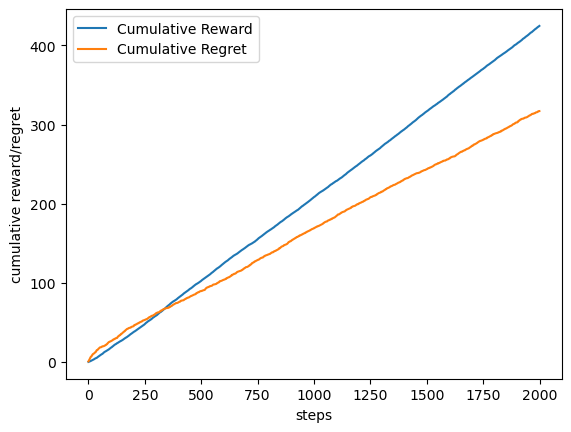

In [7]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative reward and regret
plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [ ]:
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.1176
Average reward (first 100 rounds): 0.1779
Average reward (all rounds): 0.2123

Average regret (first 10 rounds): 0.5837
Average regret (first 100 rounds): 0.2619
Average regret (all rounds): 0.1585
